In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import folium
import datetime
import holidays
from shapely.geometry import Polygon

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from plotly import __version__
import cufflinks as cf

In [3]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
%matplotlib inline

In [5]:
# Import dataset
# https://www.dataquest.io/blog/pandas-big-data/
df = pd.read_csv("RH_dataset_clean_w_censustracts.csv")

# Filter dataset
list(df.columns)

['Unnamed: 0',
 'Trip ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Trip Total',
 'Shared Trip Authorized',
 'Trips Pooled',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid Location',
 'Pickup_month',
 'Dropoff_month',
 'Pickup_day',
 'Dropoff_day',
 'Pickup_hour',
 'Dropoff_hour',
 'Pickup_day_of_week',
 'Dropoff_day_of_week',
 'Pickup_week_of_year',
 'Dropoff_week_of_year',
 'Average Speed',
 'Count']

In [6]:
# Approach 1 to month, day, hour variables out of timestamp.
# Step1: convert pickup and dropoff timestamp from objects into 
# datetime format, making analysis of date and time easier.
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"])
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"])

In [ ]:
df.info(memory_usage="deep")

In [ ]:
df.describe().astype(int)

# Optimize dtypes from float64 and int64 to float32 and int32

In [7]:
# First , change columns with dtype float64 to float32
df[["Trip Seconds", "Trip Miles", "Trip Total", "Pickup Centroid Latitude", 
    "Pickup Centroid Longitude", "Dropoff Centroid Latitude", 
    "Dropoff Centroid Longitude", "Average Speed", "Count"]] = df[["Trip Seconds", "Trip Miles", "Trip Total", 
                                                                   "Pickup Centroid Latitude", "Pickup Centroid Longitude", 
                                                                   "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Average Speed", "Count"]].astype("float32")

# Second, change variables with dtype int64 to int32.
df[["Trips Pooled", "Pickup_month", "Dropoff_month",
      "Pickup_day", "Dropoff_day", "Pickup_hour", 
      "Dropoff_hour"]] = df[["Trips Pooled", "Pickup_month", "Dropoff_month",
                                        "Pickup_day", "Dropoff_day", "Pickup_hour", 
                                        "Dropoff_hour",]].astype("int32")


# Change dtype of "Pickup_day_of_week" and "Dropoff_day_of_week"
# and "Pickup_week_of_year" and "Dropoff_week_of_year"
# from int64 to int32.
df[["Pickup_day_of_week", "Dropoff_day_of_week",
    "Pickup_week_of_year", "Dropoff_week_of_year"]] = df[["Pickup_day_of_week", "Dropoff_day_of_week",
                                                            "Pickup_week_of_year", "Dropoff_week_of_year"]].astype("int32")


In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142290 entries, 0 to 1142289
Data columns (total 29 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Unnamed: 0                  1142290 non-null  int64         
 1   Trip ID                     1142290 non-null  object        
 2   Trip Start Timestamp        1142290 non-null  datetime64[ns]
 3   Trip End Timestamp          1142290 non-null  datetime64[ns]
 4   Trip Seconds                1140087 non-null  float32       
 5   Trip Miles                  1142244 non-null  float32       
 6   Pickup Census Tract         819473 non-null   float64       
 7   Dropoff Census Tract        814967 non-null   float64       
 8   Trip Total                  1142288 non-null  float32       
 9   Shared Trip Authorized      1142290 non-null  bool          
 10  Trips Pooled                1142290 non-null  int32         
 11  Pickup Centroid Latitude

# Time-series analysis on a monthly, weekly, and hourly basis (also spatial analysis)

# First up: univariate analysis

In [11]:
df.head()

,Unnamed: 0,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Trip Total,Shared Trip Authorized,...,Dropoff_hour,Pickup_day_of_week,Dropoff_day_of_week,Pickup_week_of_year,Dropoff_week_of_year,Average Speed,Count,US_holiday,Pickup_date,is_extreme_weather
0,0,c7661e85fe9b588a0dada78c493a52e3599e435f,2019-02-04 18:30:00,2019-02-04 18:45:00,1270.0,3.8,1.703184e+10,1.703124e+10,5.05,True,...,18,0,0,6,6,10.771653,1.0,0,2019-02-04,0
1,1,c013b63cefbb16a8251586dd6ab04d31f8f42cb3,2019-01-05 02:45:00,2019-01-05 03:00:00,962.0,8.5,NaN,NaN,15.05,False,...,3,5,5,1,1,31.808731,1.0,0,2019-01-05,0
2,2,c6036c4b6dd0cfa563823a82c4472201e8f4f044,2019-01-19 16:15:00,2019-01-19 16:30:00,353.0,0.8,1.703184e+10,1.703184e+10,7.55,False,...,16,5,5,3,3,8.158640,1.0,0,2019-01-19,0
3,3,c30387fd0452828350411906001e3872954958e2,2019-01-11 15:00:00,2019-01-11 15:30:00,1221.0,6.2,1.703108e+10,1.703184e+10,15.05,False,...,15,4,4,2,2,18.280098,1.0,0,2019-01-11,0
4,4,c63cbc0d9adf033435d4d712125057ae87b430dd,2018-11-03 12:30:00,2018-11-03 12:30:00,342.0,1.9,1.703103e+10,1.703106e+10,8.50,False,...,12,5,5,44,44,20.000000,1.0,0,2018-11-03,0


In [10]:
US_national_holidays = []

for date in holidays.UnitedStates(years=[2018,2019]).items(): #items() returns dictionary.
    US_national_holidays.append(str(date[0])) # extract string representation from dates.
    
# Use list comprehension to use a for loop to create a list.
df["US_holiday"] = [1 if str(value).split()[0] in US_national_holidays else 0 for value in df["Trip Start Timestamp"]]
# df["US_holiday"] = df["US_holiday"].astype("bool")

# Convert list to datetime 
extreme_weather = ["2019-01-30"]
df["Pickup_date"] = pd.DatetimeIndex(df["Trip Start Timestamp"]).date
df["is_extreme_weather"] = [1 if str(value) in extreme_weather else 0 for value in df["Pickup_date"]]
# extreme_weather = pd.to_datetime(pd.Series("2019-01-30"), format="%Y/%m/%d")
# df["is_extreme_weather"] = df["is_extreme_weather"].astype("bool")


In [13]:
df["is_extreme_weather"].unique()
df.drop("Pickup_date", axis=1, inplace=True)


In [14]:
extreme_weather

['2019-01-30']

In [15]:
holiday_usa = []
for date in holidays.UnitedStates(years=[2018,2019]).items(): #items() returns dictionary.
    holiday_usa.append(str(date)) # extract string representation from dates.
holiday_usa


['(datetime.date(2018, 1, 1), "New Year\'s Day")',
 "(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')",
 '(datetime.date(2018, 2, 19), "Washington\'s Birthday")',
 "(datetime.date(2018, 5, 28), 'Memorial Day')",
 "(datetime.date(2018, 7, 4), 'Independence Day')",
 "(datetime.date(2018, 9, 3), 'Labor Day')",
 "(datetime.date(2018, 10, 8), 'Columbus Day')",
 "(datetime.date(2018, 11, 11), 'Veterans Day')",
 "(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')",
 "(datetime.date(2018, 11, 22), 'Thanksgiving')",
 "(datetime.date(2018, 12, 25), 'Christmas Day')",
 '(datetime.date(2019, 1, 1), "New Year\'s Day")',
 "(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')",
 '(datetime.date(2019, 2, 18), "Washington\'s Birthday")',
 "(datetime.date(2019, 5, 27), 'Memorial Day')",
 "(datetime.date(2019, 7, 4), 'Independence Day')",
 "(datetime.date(2019, 9, 2), 'Labor Day')",
 "(datetime.date(2019, 10, 14), 'Columbus Day')",
 "(datetime.date(2019, 11, 11), 'Veterans Day')",

KeyError: "None of ['Unnamed: 0'] are in the columns"

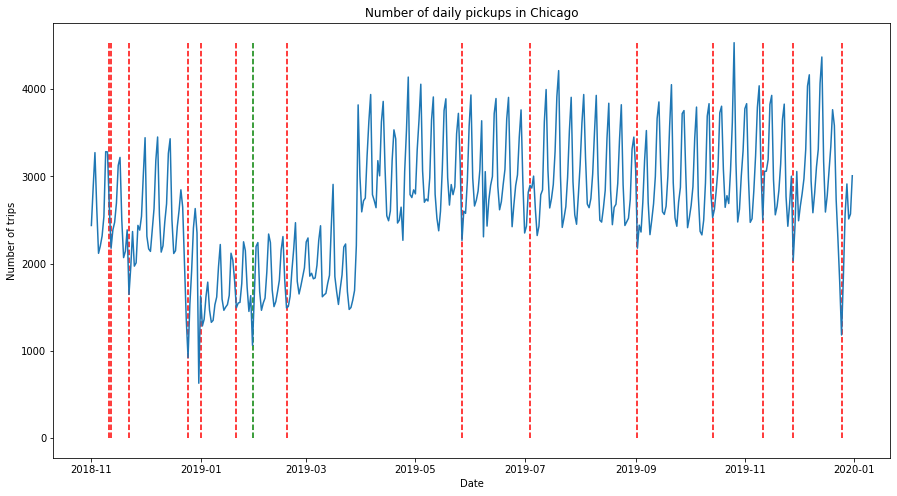

In [17]:
# Create number of daily pickups in Chicago with boolean for holiday.
# Create pandas series with boolean is_holiday
# Start by setting index to time.
# Then create a 2 columns series --> name pandas series: daily_pickups_df
# Then use conditional selection.

df.set_index("Trip Start Timestamp", inplace=True, drop=False) # set index using 1 column.
daily_pickups_df = df[["Count", "US_holiday"]]
us_holiday = daily_pickups_df.US_holiday.resample("D").sum()
us_holiday = us_holiday > 0
us_holiday = us_holiday[us_holiday]

#Creata another pandas series with boolean is_extreme weather.
extreme_weather_df = df[["is_extreme_weather"]]
bad_weather = extreme_weather_df.is_extreme_weather.resample("D").sum()
bad_weather = bad_weather > 0
bad_weather = bad_weather[bad_weather]

# Number of rides per day over the start 2018 - end 2019.
# Resample from the same pandas series, not the original dataframe.
daily_pickups = daily_pickups_df.Count.resample("D").sum()
fig = plt.figure(figsize=(15,8))
plt.plot(daily_pickups)
plt.vlines(us_holiday.index, 
           ymax=daily_pickups.max(), 
           ymin=0,
           colors="r",
           linestyles="dashed",
           label="US-holiday")
plt.vlines(bad_weather.index, 
           ymax=daily_pickups.max(), 
           ymin=0,
           colors="g",
           linestyles="dashed",
           label="Extreme weather")
plt.xlabel("Date")
plt.ylabel("Number of trips")
plt.title("Number of daily pickups in Chicago") 

# Incorporate Holiday & Weather by using boolean variables.
# Make use to use different colors for each type of event.
# For example create "is_holiday" and "is_bad_weather" columns.

#df.set_index("Unnamed: 0", inplace=True, drop=True) # Change back the index.



In [ ]:
us_holiday.index

In [ ]:
bad_weather.index

In [ ]:
# Create number of daily pickups in Chicago with boolean for extreme weather.
# Graph seperately: daily percipitation and daily wind speed, temperature too?
# Weather station: Chicago Midway Airport, IL, US: Located south side.
# Chicago weather hot summers (July-August) and cold winters (Dec-March)
# Summers are warm, humid, and wet. Winters are freezing and windy.
# Document extreme weather from November 2018 - December 2019:
# - 20190130: Extreme cold weather in late January



In [ ]:
df

In [ ]:
df["Dropoff_day_of_week"].value_counts(sort=False)
# Most Dropoffs are on Friday and Saturday. Monday has the least.


In [ ]:
# Visual time-series of trips per day of week.
# Dictionary for Weekdays.
positions = (0,1,2,3,4,5,6)
labels = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
          "Saturday", "Sunday")

df["Pickup_day_of_week"].value_counts(sort=False).plot(kind='bar')
plt.title("Number of pickups by week day")
plt.xticks(positions, labels)
# plt.savefig("Trip duration in seconds", dpi=100)

In [ ]:
positions = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
labels = ("12AM","1AM","2AM","3AM","4AM","5AM","6AM","7AM","8AM",
          "9AM","10AM","11AM","12PM","1PM","2PM","3PM","4PM","5PM",
          "6PM","7PM","8PM","9PM","10PM","11PM")
# Visual hourly time-series
df["Pickup_hour"].value_counts(sort=False).plot(kind="bar")
plt.title("Hourly pickups")
plt.xticks(positions, labels)

# Both hourly pickup and dropoff show a similar pattern:
# Low ride-hailing demand between 1AM and 5AM.
# Ride-hailing demand much higher in the morning, afternoon, and evening.
# 2 peaks during the day related to rush hours periods: 
# 1st demand surge from 5AM - 9AM with the peak at 8-9AM.
# 2nd demand surge from 4PM - 8PM with the peak at 5-7PM. 
# late afternoon rush hour (4PM - 7PM).


In [ ]:
# alternative way to plot 2 subplots using Seaborn
# HAVE TO LEARN SEABORN BASISCS!!

figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
df['Pickup_hour1']=df['Trip Start Timestamp'].dt.hour
df.Pickup_hour1.hist(bins=24,ax=ax[0])
ax[0].set_title('Distribution of pickup hours')
df['Dropoff_hour1']=df['Trip End Timestamp'].dt.hour
df.Dropoff_hour1.hist(bins=24,ax=ax[1])
ax[1].set_title('Distribution of dropoff hours')

In [ ]:
# Time-series pick-up month
positions = (0,1,2,3,4,5,6,7,8,9,10,11)
labels = ("Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

df["Pickup_month"].value_counts(sort=False).plot(kind="bar")
plt.title("Monthly pickups")
plt.xticks(positions, labels)

# The number of pickups is increases throughout the year, with large spike
# during holiday months in November and December. 
# Generally January up to and including March has the lowest demand.

In [ ]:
# Time-series pick-up week of year
positions = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,
             22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
             41,42,43,44,45,46,47,48,49,50,51)
labels = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,
             22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
             41,42,43,44,45,46,47,48,49,50,51,52)

df["Pickup_week_of_year"].value_counts(sort=False).plot(kind="bar", figsize=(10,5))
plt.title("Weekly pickups")
#plt.xticks(positions, labels)

# follows similar patter as "Pickup_month". However, plotting RH demand
# by week does help identify whether surge of RH is related to certain
# events such as holidays or sports events.

In [ ]:
df["Trip Seconds"].plot(kind="hist", bins=50)

In [ ]:
# Create function that makes a distribution of pickups and dropoffs
# during the day.
# Here, time is represented into 4 time parts: early morning (4AM - 10 AM),
# afternoon (10AM - 4PM), late afternoon/evening (4PM - 10PM)
# and late night (10PM - 4AM)

def timezone(x):
    if x>= datetime.time(6, 0, 1) and x <= datetime.time(12, 0, 0):
        return "Early Morning"
    if x>= datetime.time(12, 0, 1) and x <= datetime.time(18, 0, 0):
        return "Midday"
    if x>= datetime.time(18, 0, 1) and x <= datetime.time(24, 0, 0):
        return "Evening"
    if x>= datetime.time(24, 0, 1) and x <= datetime.time(6, 0, 0):
        return "Night"

# Bivariate Analaysis

# Visualizing pickup- and dropoff locations

In [ ]:
# Create an interactive base map.
# Default_location: start location based on coordinates.
# Zoom_start: defines default magnifing level.
def generateBaseMap(default_location=[41.881832, -87.623177], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [ ]:
base_map = generateBaseMap()
base_map

In [ ]:
# Plot heatmap.
from folium.plugins import HeatMap

df['Count'] = 1
base_map = generateBaseMap()
#Pickup coordinates
#HeatMap(data=data[["Pickup Centroid Latitude", "Pickup Centroid Longitude", "count"]].groupby(["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(bmap)

#Dropoff coordinates
HeatMap(data=df[["Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Count"]].groupby(["Dropoff Centroid Latitude", "Dropoff Centroid Longitude"]).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map


In [ ]:
# Heatmaps with a time dynamic component part 1.
pickup_hourly = []

for hour in df["Pickup_hour"].sort_values().unique():
    pickup_hourly.append(df.loc[df["Pickup_hour"] == hour, ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Count"]].groupby(["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).sum().reset_index().values.tolist())


In [ ]:
# Heatmaps with a time dynamic component part 2.
from folium.plugins import HeatMapWithTime

bmap = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(pickup_hourly, radius=5, gradient={0.1: 'blue', 0.2: 'lime', 0.5: 'orange', 0.8: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

# Need to make this HOURLY --> first make an hour and 15th minute feature.

# Mapping Chicago with Geopandas from scratch with Cencus tracts.

# Cencus Tract binning

In [ ]:
# Steps to take for cencus tract binning:
# Load on basic shapefile of Chicago
# Put on top of that layer the layer of the cencus tracts
# Can also add major streets if you want to.
# The census tracts serve as a bin to which rides are added to.
# This way you can see how much pickups and dropoffs there are in 
# each area of the city.
# Then addding a timestamp allows for dynamic visibility of demand.

# Load in shapefile.
fp = "/Users/leonpoon/Desktop/Desktop/Universiteit/Erasmus/2019-2020/BIM/Thesis/2. Data analysis and exploration/Boundaries - Census Tracts - 2010/geo_export_52ea5994-76d8-4f00-a42e-bbe33f53d5ea.shp"
map_df = gpd.read_file(fp)

# Load in GeoJSON file, because works with Folium.
geosjon_file = "Boundaries - Census Tracts - 2010.geojson"
chicago_census_tracts = gpd.read_file(geosjon_file)



In [ ]:
# Pickup by census tract.
pickup_by_censustract = pd.read_csv("pickup_demand_by_censustract_test.csv")
#pickup_demand_by_censustract = df[["Pickup Census Tract", "Count"]].groupby(["Pickup Census Tract"]).sum().reset_index().values.tolist()

# Pickup demand by lat, long location.
# pickup_demand_by_location = df[["Pickup Centroid Location", "Count"]].groupby(["Pickup Centroid Location"]).sum().reset_index().values.tolist()


In [ ]:
#pickup_demand_by_censustract = pd.DataFrame(pickup_demand_by_censustract, columns=["Pickup Census Tract", "Count"])
#pickup_demand_by_censustract.to_csv("pickup_demand_by_censustract.csv", index=False)

#pickup_demand_by_location = pd.DataFrame(pickup_demand_by_location, columns=["Pickup Centroid Location", "Count"])
#pickup_demand_by_location.to_csv("pickup_demand_by_location.csv", index=False)

#map_df["geoid10"].to_csv("geoid10", index=False)


In [ ]:
# https://vverde.github.io/blob/interactivechoropleth.html
# https://blog.datasciencedojo.com/geospatial-visualization-folium-python/
import branca.colormap as cm

# Convert Pickup Census Tract to dtype: object, as key_on object in geosjon_file is also an dtype: object
pickup_by_censustract["geoid10"] = pickup_by_censustract["geoid10"].astype(str)

# Creating Chicago map with Folium
chicago_map = folium.Map(
    location=[41.881832, -87.623177],
    zoom_start=9)
#folium.TileLayer("CartoDB positron", name="Light Map", control=False).add_to(chicago_map)

# Overlaying Chicago map with bounderies of census tracts
folium.GeoJson(chicago_census_tracts).add_to(chicago_map)

myscale = (pickup_by_censustract["Count"].quantile((0,0.1, 0.25,0.5,0.75,0.98,1))).tolist()

# Creating Choropleth
folium.Choropleth(
    geo_data=chicago_census_tracts,
    name="choropleth",
    data=pickup_by_censustract,
    columns=["geoid10", "Count"],
    key_on="feature.properties.geoid10",
    threshold_scale=myscale,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Ride-hailing demand"
).add_to(chicago_map)

folium.LayerControl().add_to(chicago_map)
chicago_map.save("ride-hailing_choropleth_chicago.html")
chicago_map

In [ ]:
# Calculate 1-100th percentile of data.

for i in range(1,100,10):
    var = pickup_by_censustract["Count"].values
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
for i in range(90,100,1):
    var = pickup_by_censustract["Count"].values
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
chicago_census_tracts=chicago_census_tracts.merge(pickup_by_censustract,on="geoid10")
chicago_census_tracts.head()

In [ ]:
style_function = lambda x: {"fillColor": "#ffffff",
                            "color":"#000000",
                            "fillOpacity": 0.1,
                            "weight": 0.1}
highlight_function = lambda x: {"fillColor": "#000000",
                                "color":"000000",
                                "fillOpacity":0.5,
                                "weight":0.1}

geoid10 = folium.features.GeoJson(
    chicago_census_tracts,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["geoid10", "Count"],
        aliases=["Census Tract: ","Number of ride-hail trips"],
        style=("background-color:white; color:#333333; font-family:arial; font-size:12px; padding:10px;")))

chicago_map.add_child(geoid10)
chicago_map.keep_in_front(geoid10)
folium.LayerControl().add_to(chicago_map)
chicago_map